# Proteomics CSF Analysis of PPMI 
We analyse **Cerebrospinal Fluid (CSF) proteomic** data of Parkinson's disease patients.
- CSF is a clear fluid that surrounds the brain and spinal cord. It provides a protective cushion for the brain and helps remove waste products.
- The collected CSF can be analyzed to look for various markers, proteins, or other substances that may be indicative of neurological conditions, including Parkinson's disease.


# XGboost ML from proteomic gene expressions among PD and Control patients.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score, auc
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier

In [2]:
# The pathes (Directories) to the data
path = Path("/home/znazari/data/open_proteomic/")
path2 = Path("/home/znazari/data/")

# Excluding from the data the patients whom they are using dopaminergic drugs or have particular mutation in their genes

In [3]:
union_drugs_mutations=pd.read_csv(path2/'union_drugs_mutations.csv', index_col=0)
s_union_drugs_mutations= union_drugs_mutations['0']

In [4]:
final_proteomic_patients=pd.read_csv(path/"final_proteomic_patients.csv")

# Remove rows where 'PATNO' is in the values of s_union_drugs_mutations
final_proteomic_patients_filtered = final_proteomic_patients[~final_proteomic_patients['PATNO'].isin(s_union_drugs_mutations)]
# Reset index
final_proteomic_patients_filtered = final_proteomic_patients_filtered.reset_index(drop=True)

In [5]:
# Save the final list of patients and their proteomic csf data into file
final_proteomic_patients_filtered.to_csv(path/'final_proteomic_patients_filtered.csv', index=False)

# Set the 'Name' column as the index
final_proteomic_patients_filtered.set_index('PATNO', inplace=True)

df = final_proteomic_patients_filtered
df

,COHORT,10000-28_3,10001-7_3,10003-15_3,10006-25_3,10008-43_3,10009-2_3,10010-10_3,10011-65_3,10012-5_3,...,9984-12_3,9986-14_3,9987-30_3,9989-12_3,9991-112_3,9993-11_3,9994-217_3,9995-6_3,9997-12_3,9999-1_3
PATNO,,,,,,,,,,,,,,,,,,,,,
3029,0,6.881810,7.698871,6.235733,6.397376,5.898213,5.814846,6.204347,7.770759,6.309053,...,6.000616,9.258282,5.840534,6.320405,7.183427,6.182855,6.954768,9.604112,8.947430,9.358625
3963,1,6.843277,7.940987,6.253929,6.248572,5.881750,5.813261,6.203654,7.828046,6.263731,...,6.169101,8.977272,5.852367,6.352225,6.882810,6.252332,6.960120,9.578161,8.595830,9.151849
3316,0,6.833672,8.154299,6.226679,6.417975,5.950047,5.731352,6.329086,7.940774,6.328306,...,6.054259,8.856002,5.765146,6.259030,7.287134,6.254280,7.052670,9.688273,9.096634,9.614637
3124,1,6.685086,7.365837,6.227807,6.318911,6.109293,5.822314,6.023443,7.706822,6.288972,...,6.186214,8.766998,5.939028,6.361248,7.139187,6.364042,7.523021,8.960747,8.346206,9.197527
3175,1,6.984575,8.301633,6.211235,6.411799,5.994321,5.863646,6.282596,7.934654,6.257924,...,6.102391,9.922082,5.726641,6.259768,6.818141,6.236396,7.159039,9.780839,8.825444,9.373566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,0,7.014804,7.469007,6.306823,6.314757,5.893445,6.001855,6.143816,7.752982,6.460554,...,6.270356,8.784713,6.170978,6.270834,6.675186,6.919316,7.224437,8.986365,8.306326,9.158217
3817,0,6.787784,7.847977,6.257174,6.412752,5.943464,5.825788,6.183518,7.829379,6.233162,...,6.128340,9.528539,5.840993,6.326199,7.422274,6.160604,7.063162,9.438577,8.590444,9.395105
3792,1,6.881702,7.962447,6.224932,6.268376,6.019198,5.847903,6.152021,7.931321,6.283648,...,6.222008,9.231704,6.029250,6.332100,7.402976,6.506793,6.756406,9.300107,8.453467,9.147362


## Pearson's Correlation


In [6]:
# Extracting gene expression and diagnosis columns
gene_expression = df.drop('COHORT', axis=1)  # Drop 'Diagnosis' column from gene expression data
diagnosis = df['COHORT']

# Calculate Pearson correlation for each gene and store in a dictionary
correlation_dict = {}
for gene in gene_expression.columns:
    correlation_coefficient, _ = pearsonr(gene_expression[gene], diagnosis)
    correlation_dict[gene] = abs(correlation_coefficient)

# Sort the genes by the absolute correlation coefficient in descending order
sorted_genes = sorted(correlation_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the top 50% of genes
top_20_percent = int(0.5 * len(sorted_genes))
selected_genes = [gene[0] for gene in sorted_genes[:top_20_percent]]


## XGboost algorithm with hyperparametrs 

In [7]:
# Define hyperparameters and seed
hyperparameters = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 300}
seed = 42

# Keep only the columns in the selected_genes list
selected_gene_expression = gene_expression[selected_genes]

# Separate features (X) and target variable (y)
X = selected_gene_expression
y = diagnosis

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(**hyperparameters, seed=seed)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate AU-ROC score
au_roc_score = roc_auc_score(y_test, y_pred_proba)
print(f'AU-ROC Score: {au_roc_score:.4f}')

# Optional: Cross-validation
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=10, scoring='roc_auc')
print(f'Cross-validated AU-ROC Scores: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})')


AU-ROC Score: 0.7889
Cross-validated AU-ROC Scores: 0.7559 (±0.0589)


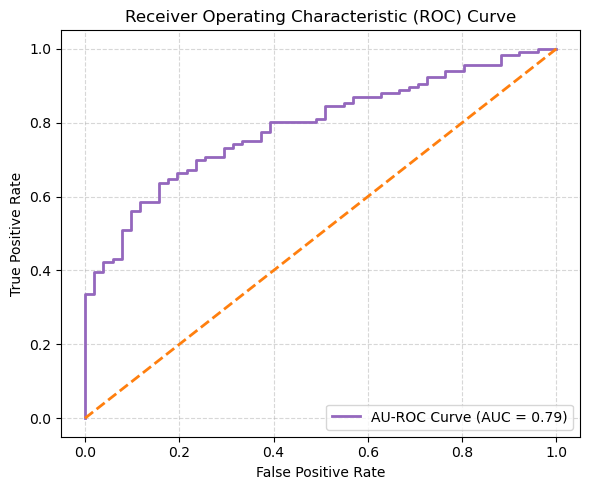

In [8]:
# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Create a new figure
plt.figure(figsize=(6, 5))

# Plot the ROC curve
plt.plot(fpr, tpr, color='tab:purple', lw=2, label=f'AU-ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='tab:orange', lw=2, linestyle='--')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()


In [9]:
# Get the current date
current_date = datetime.now().date()

# Print the current date
print("Last update :", current_date)

Last update : 2024-02-29
